# COVID-19 Abstract Analysis with NLP  
### spaCy-Based Pipeline for Biomedical Text Processing

## Overview

This project analyzes a corpus of 333 scientific abstracts related to COVID-19, retrieved from PubMed and originally published in *Science*.

The objective is to explore natural language processing (NLP) techniques for biomedical text, combining:
- Linguistic processing using **spaCy**
- Text analysis techniques (tokenization, POS tagging, NER, TF–IDF)
- Structured data handling with **pandas**

## Dataset

The dataset consists of XML-formatted abstracts (`covid_ds_full.xml`) collected via PubMed search.


In [ ]:
# Core data handling and analysis
import pandas as pd

# Regular expressions for text preprocessing
import re

# Visualization
import matplotlib.pyplot as plt

# XML parsing for PubMed dataset
import xml.etree.ElementTree as ET

# Mathematical utilities
from numpy import log

# File handling (Colab-specific)
from google.colab import files

# Frequency analysis
from collections import Counter


In [ ]:
covid = files.upload()

Saving covid_ds_full.xml to covid_ds_full (2).xml


## XML Structure

The dataset is provided in XML format, a hierarchical markup structure commonly used for scientific data (e.g., PubMed records).

XML elements may contain:
- **Attributes** (e.g., metadata such as type or ID)
- **Text content** (e.g., abstract text)
- **Nested elements** (representing hierarchical relationships)

Due to its flexible structure, XML is not directly suitable for analysis.  
Therefore, it is parsed and converted into a structured format (e.g., a pandas DataFrame) before further processing.


In [ ]:
def generate_covid_df():
    articles=[]
    tree= ET.parse("covid_ds_full.xml")
    root= tree.getroot()
    for x in root.iter("PubmedArticle"):
        articles_in_pm_article=list(x.iter("Article"))
        if len(articles_in_pm_article)> 1: continue
        article= articles_in_pm_article[0]
        doc_id=int(list(x.iter("PMID"))[0].text)
        title=list(article.iter("ArticleTitle"))[0].text
        pubdate=list(article.iter("PubDate"))[0]
        year=int(pubdate.find("Year").text)
        abstracts=list(article.iter("AbstractText"))
        if len(abstracts) !=1: continue
        abstract= abstracts[0].text
        article_dict = {"doc_id":doc_id,"Title":title, "year":year,"Abstract":abstract}
        articles.append(article_dict)
    covid_df = pd.DataFrame(articles)
    return covid_df



In [ ]:
covid_df = generate_covid_df()
print(len(covid_df))
covid_df.head()

333


,doc_id,Title,year,Abstract
0,37972180,"Humans are biocultural, science should be too.",2023,COVID-19 is restructuring societies. Lonelines...
1,37972171,The responsibility turn,2023,Lessons from the COVID-19 pandemic inspire a g...
2,37943961,Correction is courageous.,2023,In a year when disagreements over scientific m...
3,37943932,Open science discovery of potent noncovalent S...,2023,"We report the results of the COVID Moonshot, a..."
4,37943911,Preparing for the next pandemic.,2023,New lead drugs to treat COVID-19 are beginning...


## Data Overview

The extracted data is stored in a pandas DataFrame (`covid_df`), which serves as the main structure for downstream analysis.

The dataset contains the following columns:


In [ ]:
covid_df.columns

Index(['doc_id', 'Title', 'year', 'Abstract'], dtype='object')

## Dataset Size

The dataset contains the following number of valid abstracts:


In [ ]:
len(covid_df)

333

## Publication Year Distribution

The distribution of articles by publication year provides an overview of how COVID-19 research evolved over time.


In [ ]:
covid_df.groupby('year').count()

,doc_id,Title,Abstract
year,,,
2020,82,82,82
2021,104,104,104
2022,104,104,104
2023,43,43,43


In [ ]:
covid_df["year"].value_counts()

,count
year,
2022,104
2021,104
2020,82
2023,43


## Text Length Analysis

To support basic textual analysis, we compute the number of words in each abstract.  
This metric provides a simple proxy for document length and variability across the dataset.



In [ ]:
def num_words(sentence):
    '''
    Calculate the number of words in the sentence.
    '''
    num_words=len(sentence.split(" "))
    return num_words

In [ ]:
#find number of words in a sample abstract
random_row = covid_df.sample(n=1)
random_abstract = random_row['Abstract'].values[0]
print(random_abstract)

Broadly protective vaccines against known and preemergent human coronaviruses (HCoVs) are urgently needed. To gain a deeper understanding of cross-neutralizing antibody responses, we mined the memory B cell repertoire of a convalescent severe acute respiratory syndrome (SARS) donor and identified 200 SARS coronavirus 2 (SARS-CoV-2) binding antibodies that target multiple conserved sites on the spike (S) protein. A large proportion of the non-neutralizing antibodies display high levels of somatic hypermutation and cross-react with circulating HCoVs, suggesting recall of preexisting memory B cells elicited by prior HCoV infections. Several antibodies potently cross-neutralize SARS-CoV, SARS-CoV-2, and the bat SARS-like virus WIV1 by blocking receptor attachment and inducing S1 shedding. These antibodies represent promising candidates for therapeutic intervention and reveal a target for the rational design of pan-sarbecovirus vaccines.


In [ ]:
num_words_abstract=num_words(random_abstract)
print(num_words_abstract)

126


In [ ]:
#find number of words for all abstracts
lengths = covid_df.Abstract.apply(lambda abstract: num_words(abstract))
print(lengths)

0       49
1       14
2      132
3      130
4       10
      ... 
328     30
329    146
330    145
331     49
332    160
Name: Abstract, Length: 333, dtype: int64


## Abstract Length Distribution

We compute the word count for each abstract and analyze its distribution to better understand variability in document length across the dataset.


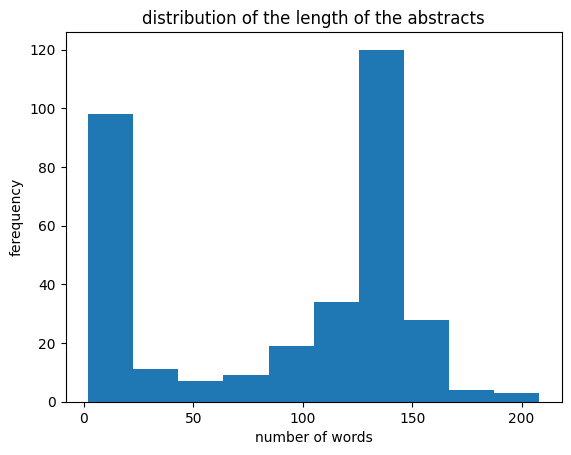

In [ ]:
# display distribution of the length of the abstracts
plt.hist(lengths)
plt.xlabel('number of words')
plt.ylabel('ferequency')
plt.title('distribution of the length of the abstracts')
plt.show()

## Filtering Data

DataFrames can be filtered by applying conditions to column values.  
A common approach is to evaluate a function on each entry and retain rows that satisfy a given condition.

For example:



In [ ]:
covid_df_50_words = covid_df[covid_df["Abstract"].apply(lambda Abstract: num_words(Abstract)>=50)]

## Introduction to spaCy

## spaCy for NLP Processing

spaCy is an industrial-grade NLP library used for efficient text processing tasks such as tokenization, part-of-speech tagging, and named entity recognition.

In this project, we use the `en_core_web_sm` model, which provides a lightweight and fast pipeline suitable for processing large collections of abstracts.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Tokenization with spaCy

We use spaCy to break text into individual words (tokens).

Here, we apply it to the title of one document and list all tokens.


In [ ]:
def get_token(x):
    doc_token=nlp(x)
    token=[token.text for token in doc_token]
    return token

In [ ]:
def get_token_pos(y):
    doc_pos=nlp(y)
    token_pos=[token.pos_ for token in doc_pos]
    return token_pos

In [ ]:
def get_token_lemma(z):
    doc_lemma=nlp(z)
    token_lemma=[token.lemma_ for token in doc_lemma]
    return token_lemma

In [ ]:
id= 33906968
title_id=covid_df.loc[covid_df['doc_id']==id,'Title'].values[0]
token_title=get_token(title_id)
print(token_title)

['Socioeconomic', 'status', 'determines', 'COVID-19', 'incidence', 'and', 'related', 'mortality', 'in', 'Santiago', ',', 'Chile', '.']


## Part-of-Speech (POS) Tagging

We can also extract the grammatical role (POS) of each token using spaCy.


In [ ]:
token_pos_title=get_token_pos(title_id)
print(token_pos_title)

['ADJ', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT']


## Lemmatization

Lemmatization reduces words to their base form (e.g., "running" → "run").  
This helps normalize text and reduce vocabulary size.


In [ ]:
token_lemma_title=get_token_lemma(title_id)
print(token_lemma_title)

['socioeconomic', 'status', 'determine', 'covid-19', 'incidence', 'and', 'related', 'mortality', 'in', 'Santiago', ',', 'Chile', '.']


## Vocabulary Size Analysis

We compare the number of unique words and unique lemmas across all abstracts to evaluate how lemmatization reduces vocabulary size.


In [ ]:
# preprocess text and clean it
def get_cleaned_text(text):
    capital_remove= text.lower()
    punc_remove= re.sub(r'[^\w\s]', '', capital_remove)
    cleaned_text=punc_remove
    return cleaned_text

In [ ]:
#remove capital letters and punctuations from all abstracts
covid_df['cleaned_abstract']=covid_df.Abstract.apply(get_cleaned_text)

In [ ]:
covid_df['Tokens']=covid_df.cleaned_abstract.apply(get_token)

In [ ]:
covid_df['pos']=covid_df.cleaned_abstract.apply(get_token_pos)

In [ ]:
covid_df['lemma']=covid_df.cleaned_abstract.apply(get_token_lemma)

In [ ]:
flattened_token= [item for sublist in covid_df['Tokens'] for item in sublist]
flattened_pos=[item for sublist in covid_df['pos'] for item in sublist]
flattened_lemma=[item for sublist in covid_df['lemma'] for item in sublist]

## POS Distribution

We analyze the distribution of part-of-speech (POS) tags across all abstracts to understand the linguistic structure of the dataset.


In [ ]:
def get_counter_df(list):
    counter_list=Counter(list)
    counter_df= pd.DataFrame(counter_list.items(),columns=['items','counter'])
    return counter_df

In [ ]:
#quantity of unique terms in all abstracts
token_df=get_counter_df(flattened_token)
print(token_df)

                     items  counter
0                  covid19      224
1                       is      192
2            restructuring        1
3                societies        2
4               loneliness        1
...                    ...      ...
5063        countermeasure        1
5064  35angstromresolution        1
5065    receptoraccessible        1
5066           biophysical        1
5067           appreciable        1

[5068 rows x 2 columns]


In [ ]:
pos_df= get_counter_df(flattened_pos)
print(pos_df)

    items  counter
0   PROPN     1424
1     AUX      970
2    VERB     3664
3    NOUN     9102
4     DET     2240
5     ADJ     3922
6   CCONJ     1208
7   SCONJ      451
8    PRON      906
9     ADP     3817
10    ADV      894
11   PART      441
12    NUM      979
13      X       28
14  SPACE        5
15  PUNCT        4
16   INTJ        5


In [ ]:
#quantity of unique lemmas in all abstracts
lemma_df=get_counter_df(flattened_lemma)
print(lemma_df)

                     items  counter
0                  covid19      224
1                       be      606
2              restructure        1
3                  society        4
4               loneliness        1
...                    ...      ...
4171                   cov        1
4172  35angstromresolution        1
4173    receptoraccessible        1
4174           biophysical        1
4175           appreciable        1

[4176 rows x 2 columns]


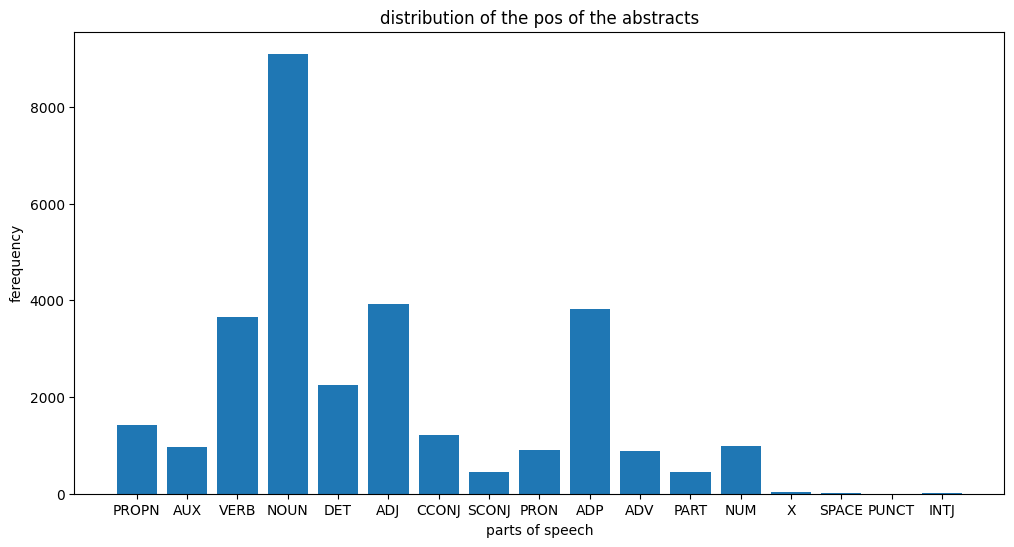

In [ ]:
#distribution of POS over the all the abstracts
plt.figure(figsize=(12, 6))
plt.bar(x=pos_df["items"],height=pos_df["counter"])
plt.xlabel('parts of speech')
plt.ylabel('ferequency')
plt.title('distribution of the pos of the abstracts')
plt.show()

## Most Frequent Words (Zipf Analysis)

We analyze the 100 most frequent words across all abstracts (excluding punctuation and spaces).  
Frequencies are plotted on a logarithmic scale to observe their distribution.


In [ ]:
sorted_tokens=token_df.sort_values(by='counter', ascending=False)
maximum_tokens=sorted_tokens.head(100)

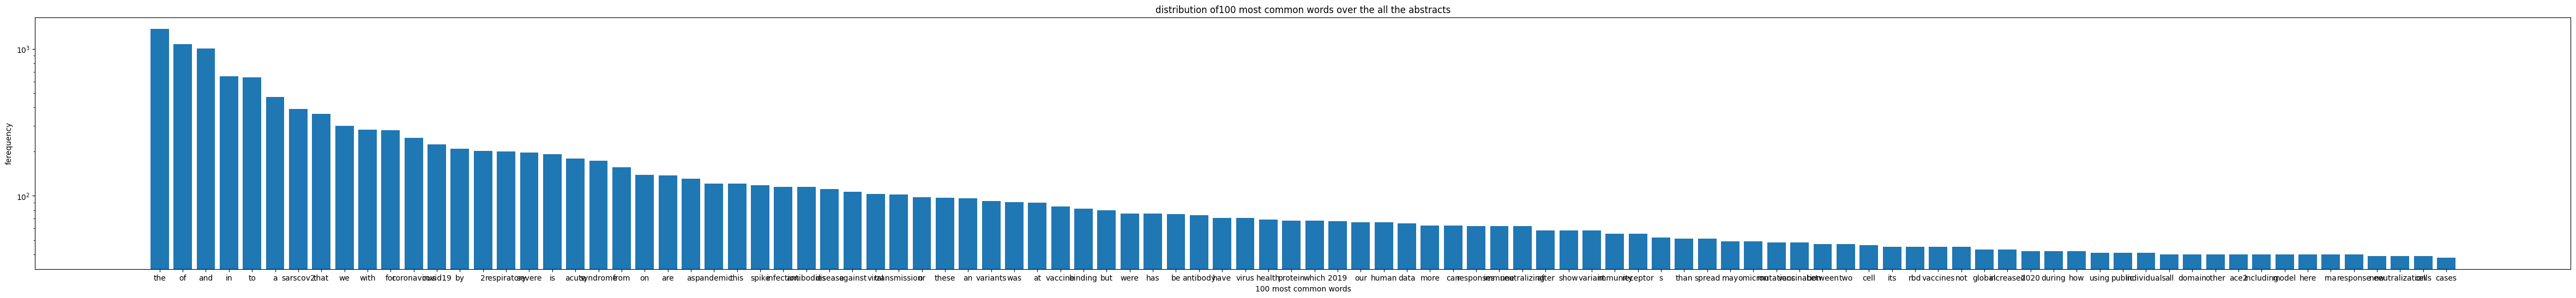

In [ ]:
#distribution of 100 most common words over the all the abstracts
plt.figure(figsize=(60, 6))
plt.bar(x=maximum_tokens["items"],height=maximum_tokens["counter"])
plt.yscale('log')
plt.xlabel('100 most common words')
plt.ylabel('ferequency')
plt.title('distribution of100 most common words over the all the abstracts')
plt.show()

## Stop Words Removal and Text Normalization

Stop words (e.g., "the", "and") often carry little semantic meaning and can be removed in tasks focused on content analysis.  
However, they may still be important in tasks involving syntax or language structure.

Here, we remove stop words and convert remaining tokens to their lemma form to create a normalized version of each abstract.


In [ ]:
import re

def clean_stop_words(text):
    doc = nlp(text)
    out = []
    for t in doc:
        tok = t.lemma_.lower()
        if t.is_stop:
            continue
        # keep words like covid19, sarscov2, il6, but drop pure punctuation/space
        if re.search(r"[a-zA-Z]", tok):   # contains at least one letter
            tok = re.sub(r"[^a-z0-9]+", "", tok)  # normalize separators
            if tok:
                out.append(tok)
    return out


In [ ]:
covid_df["abstract_wo_stop_words"] = covid_df["cleaned_abstract"].apply(clean_stop_words)


In [ ]:
covid_df.head()

,doc_id,Title,year,Abstract,cleaned_abstract,Tokens,pos,lemma,abstract_wo_stop_words
0,37972180,"Humans are biocultural, science should be too.",2023,COVID-19 is restructuring societies. Lonelines...,covid19 is restructuring societies loneliness ...,"[covid19, is, restructuring, societies, loneli...","[PROPN, AUX, VERB, NOUN, NOUN, AUX, DET, ADJ, ...","[covid19, be, restructure, society, loneliness...","[covid19, restructure, society, loneliness, gl..."
1,37972171,The responsibility turn,2023,Lessons from the COVID-19 pandemic inspire a g...,lessons from the covid19 pandemic inspire a gu...,"[lessons, from, the, covid19, pandemic, inspir...","[NOUN, ADP, DET, ADJ, ADJ, VERB, DET, NOUN, AD...","[lesson, from, the, covid19, pandemic, inspire...","[lesson, covid19, pandemic, inspire, guide, re..."
2,37943961,Correction is courageous.,2023,In a year when disagreements over scientific m...,in a year when disagreements over scientific m...,"[in, a, year, when, disagreements, over, scien...","[ADP, DET, NOUN, SCONJ, NOUN, ADP, ADJ, NOUN, ...","[in, a, year, when, disagreement, over, scient...","[year, disagreement, scientific, matter, like,..."
3,37943932,Open science discovery of potent noncovalent S...,2023,"We report the results of the COVID Moonshot, a...",we report the results of the covid moonshot a ...,"[we, report, the, results, of, the, covid, moo...","[PRON, VERB, DET, NOUN, ADP, DET, ADJ, NOUN, D...","[we, report, the, result, of, the, covid, moon...","[report, result, covid, moonshot, fully, opens..."
4,37943911,Preparing for the next pandemic.,2023,New lead drugs to treat COVID-19 are beginning...,new lead drugs to treat covid19 are beginning ...,"[new, lead, drugs, to, treat, covid19, are, be...","[ADJ, ADJ, NOUN, PART, VERB, NOUN, AUX, VERB, ...","[new, lead, drug, to, treat, covid19, be, begi...","[new, lead, drug, treat, covid19, begin, emerge]"


## Dependency Parsing

spaCy can identify relationships between words in a sentence (dependency parsing).  
We visualize these relationships for a sample title using `displacy`.


In [ ]:
from spacy import displacy

In [ ]:
random_row = covid_df.sample(n=1)
random_title = random_row['Title'].values[0]
print("random_title is:",random_title)
random_title_doc=nlp(random_title)
actual=[]
POS=[]
head=[]
for word in random_title_doc:
    actual_word=actual.append(word.text)
    POS_word=POS.append(word.tag_)
    head_word=head.append(word.head)
    df_dep=pd.DataFrame({'actual_word': actual,'POS':POS,'head': head})
print(df_dep)
displacy.render(random_title_doc, style='dep', jupyter=True, options={'distance': 130})

random_title is: Transmission of SARS-CoV-2 on mink farms between humans and mink and back to humans.
     actual_word   POS          head
0   Transmission    NN  Transmission
1             of    IN  Transmission
2           SARS   NNP         CoV-2
3              -  HYPH         CoV-2
4          CoV-2   NNP            of
5             on    IN  Transmission
6           mink    NN         farms
7          farms   NNS            on
8        between    IN         farms
9         humans   NNS       between
10           and    CC        humans
11          mink    NN        humans
12           and    CC            on
13          back    RB            on
14            to    IN          back
15        humans   NNS            to
16             .     .  Transmission


## Named Entity Analysis

We extract named entities from all abstracts and analyze:
- the most frequent entities
- the most common entity types (labels)


In [ ]:
def get_named_entity(sentence):
    name_list=[]
    for ent in nlp(sentence).ents:
        name_list.append(ent.text)
    return name_list

In [ ]:
def get_label_entity(sentence):
    label_list=[]
    for ent in nlp(sentence).ents:
        label_list.append(ent.label_)
    return label_list

In [ ]:
covid_df['named_entity']=covid_df.Abstract.apply(get_named_entity)
covid_df['label_entity']=covid_df.Abstract.apply(get_label_entity)

In [ ]:
flattened_named_entity= [item for sublist in covid_df['named_entity'] for item in sublist]
flattened_label_entity=[item for sublist in covid_df['label_entity'] for item in sublist]

In [ ]:
name_entity_df=get_counter_df(flattened_named_entity)
label_entity_df=get_counter_df(flattened_label_entity)

In [ ]:
sorted_entities=name_entity_df.sort_values(by='counter', ascending=False)
maximum_entities=sorted_entities.head(20)
print(maximum_entities)

                 items  counter
5                    2      197
0             COVID-19      142
46                2019       60
29             Omicron       54
37                 two       42
136               ACE2       42
54               China       32
88               Delta       30
53               Wuhan       29
612                IFN       25
169                RBD       24
179              three       24
140         SARS-CoV-2       23
193                RNA       21
23               first       19
71                 one       18
2    the United States       18
268            B.1.1.7       15
216                95%       14
267            B.1.351       13


In [ ]:
sorted_labels=label_entity_df.sort_values(by='counter', ascending=False)
maximum_labels=sorted_labels.head(20)
print(maximum_labels)

          items  counter
4      CARDINAL      547
0           ORG      464
1          DATE      269
3           GPE      201
2        PERSON      171
6       PERCENT      124
11         NORP       56
9           LOC       46
5       ORDINAL       38
12      PRODUCT       34
7         MONEY        8
13          FAC        8
15     QUANTITY        5
16  WORK_OF_ART        3
10         TIME        3
8      LANGUAGE        1
14          LAW        1


## TF–IDF

TF–IDF (term frequency–inverse document frequency) measures how important a term is to a document relative to a corpus.

A term has a high TF–IDF score if it appears frequently in a document but rarely across the corpus.

We implement TF and IDF to compute term importance across the cleaned abstracts.



In [ ]:
covid_df.head()

,doc_id,Title,year,Abstract,cleaned_abstract,Tokens,pos,lemma,abstract_wo_stop_words,named_entity,label_entity
0,37972180,"Humans are biocultural, science should be too.",2023,COVID-19 is restructuring societies. Lonelines...,covid19 is restructuring societies loneliness ...,"[covid19, is, restructuring, societies, loneli...","[PROPN, AUX, VERB, NOUN, NOUN, AUX, DET, ADJ, ...","[covid19, be, restructure, society, loneliness...","[covid19, restructure, society, loneliness, gl...",[],[]
1,37972171,The responsibility turn,2023,Lessons from the COVID-19 pandemic inspire a g...,lessons from the covid19 pandemic inspire a gu...,"[lessons, from, the, covid19, pandemic, inspir...","[NOUN, ADP, DET, ADJ, ADJ, VERB, DET, NOUN, AD...","[lesson, from, the, covid19, pandemic, inspire...","[lesson, covid19, pandemic, inspire, guide, re...",[COVID-19],[ORG]
2,37943961,Correction is courageous.,2023,In a year when disagreements over scientific m...,in a year when disagreements over scientific m...,"[in, a, year, when, disagreements, over, scien...","[ADP, DET, NOUN, SCONJ, NOUN, ADP, ADJ, NOUN, ...","[in, a, year, when, disagreement, over, scient...","[year, disagreement, scientific, matter, like,...","[a year, COVID-19, the United States, the Whit...","[DATE, PERSON, GPE, ORG, ORG]"
3,37943932,Open science discovery of potent noncovalent S...,2023,"We report the results of the COVID Moonshot, a...",we report the results of the covid moonshot a ...,"[we, report, the, results, of, the, covid, moo...","[PRON, VERB, DET, NOUN, ADP, DET, ADJ, NOUN, D...","[we, report, the, result, of, the, covid, moon...","[report, result, covid, moonshot, fully, opens...","[2, 18,000, 490, 10,000, 2400]","[CARDINAL, CARDINAL, CARDINAL, CARDINAL, CARDI..."
4,37943911,Preparing for the next pandemic.,2023,New lead drugs to treat COVID-19 are beginning...,new lead drugs to treat covid19 are beginning ...,"[new, lead, drugs, to, treat, covid19, are, be...","[ADJ, ADJ, NOUN, PART, VERB, NOUN, AUX, VERB, ...","[new, lead, drug, to, treat, covid19, be, begi...","[new, lead, drug, treat, covid19, begin, emerge]",[],[]


In [ ]:
import numpy as np

def tf(word, doc_tokens):
    return doc_tokens.count(word) / len(doc_tokens) if doc_tokens else 0.0

def idf(word, corpus_tokens):
    N = len(corpus_tokens)
    df = sum(1 for doc in corpus_tokens if word in doc)
    return np.log(N / (df + 1))

def tf_idf(word, doc_tokens, corpus_tokens):
    return tf(word, doc_tokens) * idf(word, corpus_tokens)


In [ ]:
my_abs = covid_df.loc[covid_df.doc_id == 37943961, "abstract_wo_stop_words"].iloc[0]

corpus = covid_df["abstract_wo_stop_words"].tolist()

tf_idf("covid19", my_abs, corpus)



np.float64(0.011488516914785496)

## Conclusion

In this project, we applied NLP techniques to analyze COVID-19 abstracts, including tokenization, lemmatization, POS tagging, named entity recognition, and TF–IDF.

The analysis revealed common patterns in scientific writing, such as frequent use of nouns and domain-specific terms. Word frequency and TF–IDF helped identify the most relevant terms in the corpus.

This pipeline shows how unstructured text can be transformed into structured information. It can be extended with more advanced or domain-specific tools for deeper biomedical analysis.

